# Portfolio assignment week 7

We'll be bagging and boosting today.

"Bagging" and "boosting" are two prominent ensemble learning strategies in scikit-learn for improving the performance of machine learning models. Both strategies include the combination of numerous distinct models in order to generate a more accurate and robust predictive model.

- Bagging: Bagging is a technique that includes bootstrapping numerous subsets of the original training dataset. Each subset is used to train a different base model, which is usually done with the same learning algorithm. To create predictions, these base models are integrated using a voting mechanism (for classification problems) or averaging (for regression problems). Bagging is based on the premise that training multiple models on various subsets of data and pooling their predictions can assist minimize variation and enhance overall model performance. An ensemble approach that uses bagging is the Random Forest algorithm in scikit-learn.

- Boosting: Another ensemble technique is boosting, in which base models are trained successively, with each succeeding model attempting to fix the mistakes caused by the prior models. Boosting involves training each base model using a modified version of the training dataset in which the weights of the misclassified cases are increased, encouraging the model to focus more on those instances in following iterations. By integrating the predictions of numerous weak models, boosting attempts to generate a strong overall model. Popular boosting algorithms included in scikit-learn include AdaBoost and Gradient Boosting.

We'll be using the cancer data set. You know, the one we'll be utilizing throughout the course.  

In [15]:
# modules needed fot this task
import pandas as pd 
import numpy as np 
import yaml
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# The data
We will make use of the breast cancer data. 
This data is ideal for this type of study because it just contains two classes that we can categorize based on the qualities provide.
firs we going to check a view things:

- NAN values
- correlation
- shape of the data 
- scaling the data

#### loading and preprocces the data

In [4]:
with open("config.yml") as config:
    input_files = yaml.safe_load(config)
    df = pd.read_csv(input_files["cancer"])
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



### Exploratory analysis
Checks:
- examining nana values
- skewness 
- column correlation 
- classes within the data 


In [5]:
NAN = df.isna().sum().sum() # check nan
row = df.shape[0] # shape 
col = df.shape[1] # shape
print(f'the amount of rows:{row}, the amount of columns:{col}')
print(f'amount of NAN values:{NAN}')
print(f'types of classes in data {df["diagnosis"].unique()}')

the amount of rows:569, the amount of columns:32
amount of NAN values:0
types of classes in data ['M' 'B']


### Check destribution for both classes

In [6]:
# filter the two diagnosis for plotting later
B_df_col = df.loc[df["diagnosis"] == "B"]
M_df_col = df.loc[df["diagnosis"] == "M"]

B_df_col = B_df_col.drop(columns=["diagnosis","id"])
M_df_col = M_df_col.drop(columns=["diagnosis","id"])

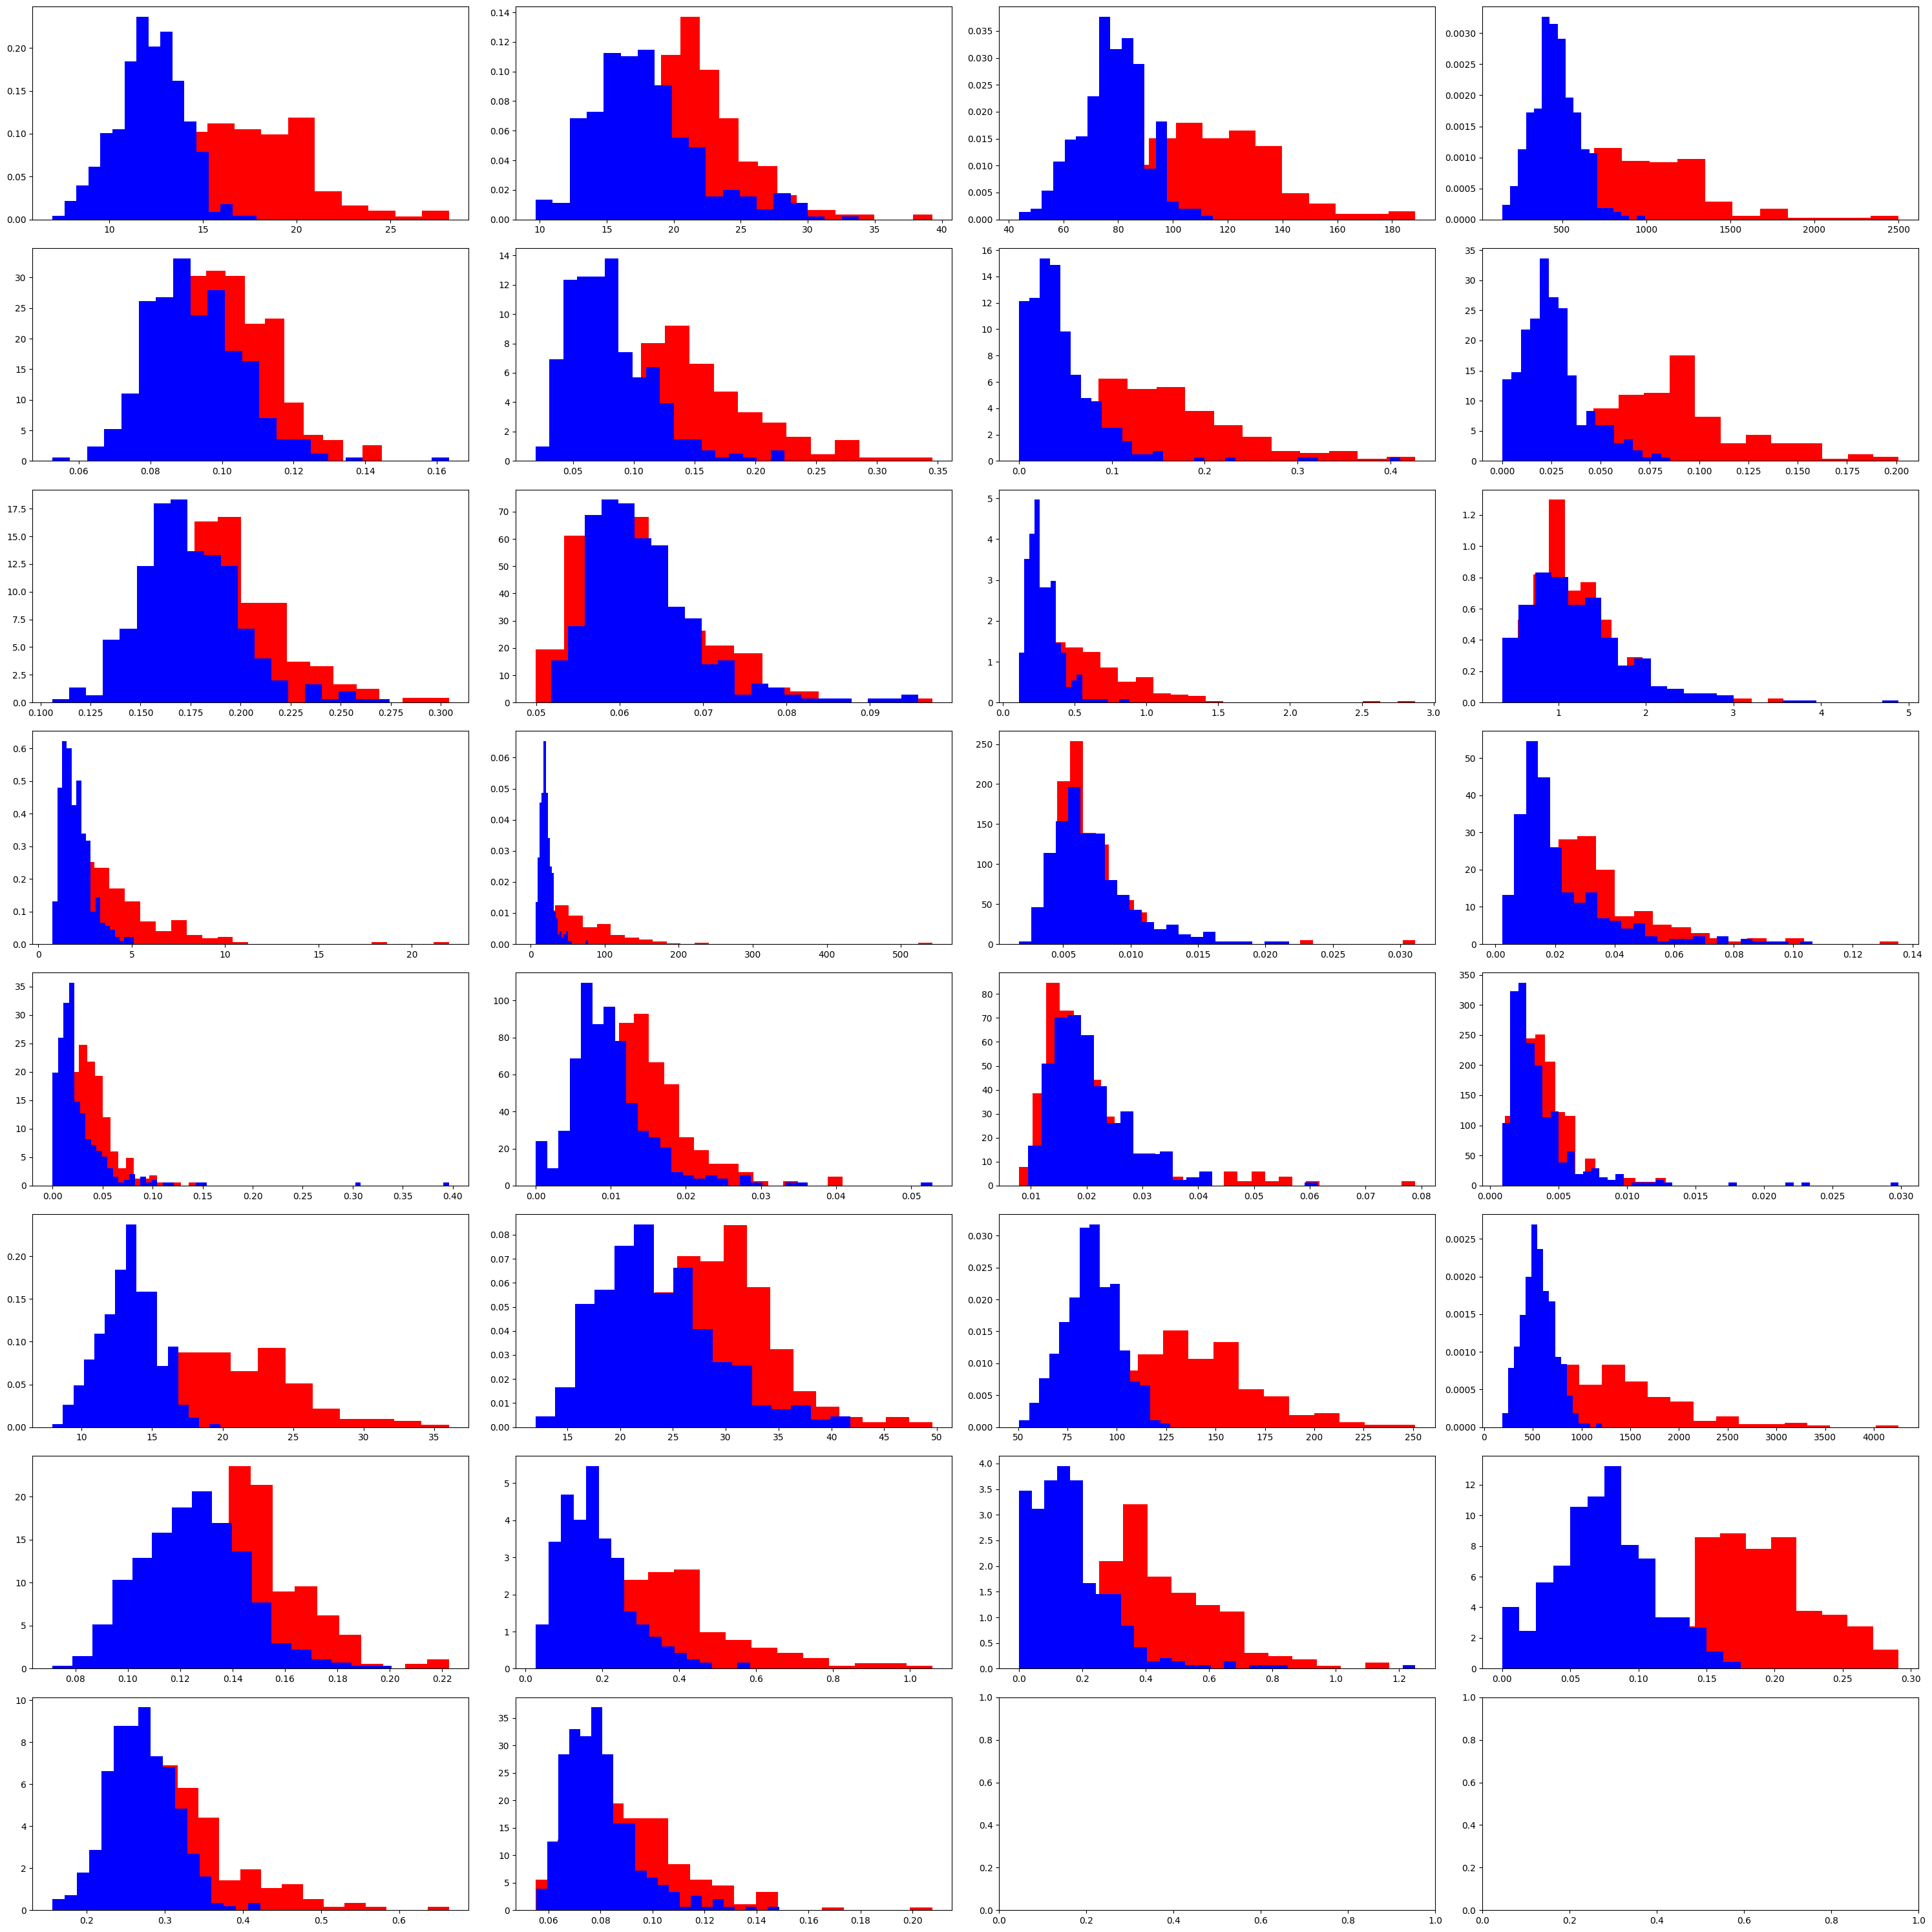

In [7]:

num_cols = 4  # Number of columns in the grid
num_rows = 8 # Number of rows in the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

axes = axes.flatten()
c=0 
for c1 in M_df_col.columns:
    try:
        axes[c].hist(M_df_col[c1],bins="auto",color ="red",density = True)
        axes[c].hist(B_df_col[c1],bins="auto",color ="blue",density = True)
        c+=1
    except: IndexError
# blue will be the beneign because it is not as harmfull and red will be the malignant cause you know it is deadly
plt.tight_layout()
plt.show()

The distribution appears to be sufficient. 
We can now look at the relationship between the qualities to see if any of the associated elements should be removed or consolidated into a single feature.
This is because categorizing a class based on attributes that correspond is more challenging.
For example, the difference between a bike and a car is noticeable because they have completely different aspects that make it look like a bike or a car, but if they share 90% of the traits, it becomes much more difficult to distinguish the two objects. The computer operates in the same way; if a class has unique characteristics, it is much easier to classify this thing into a specific class of objects.

<Axes: >

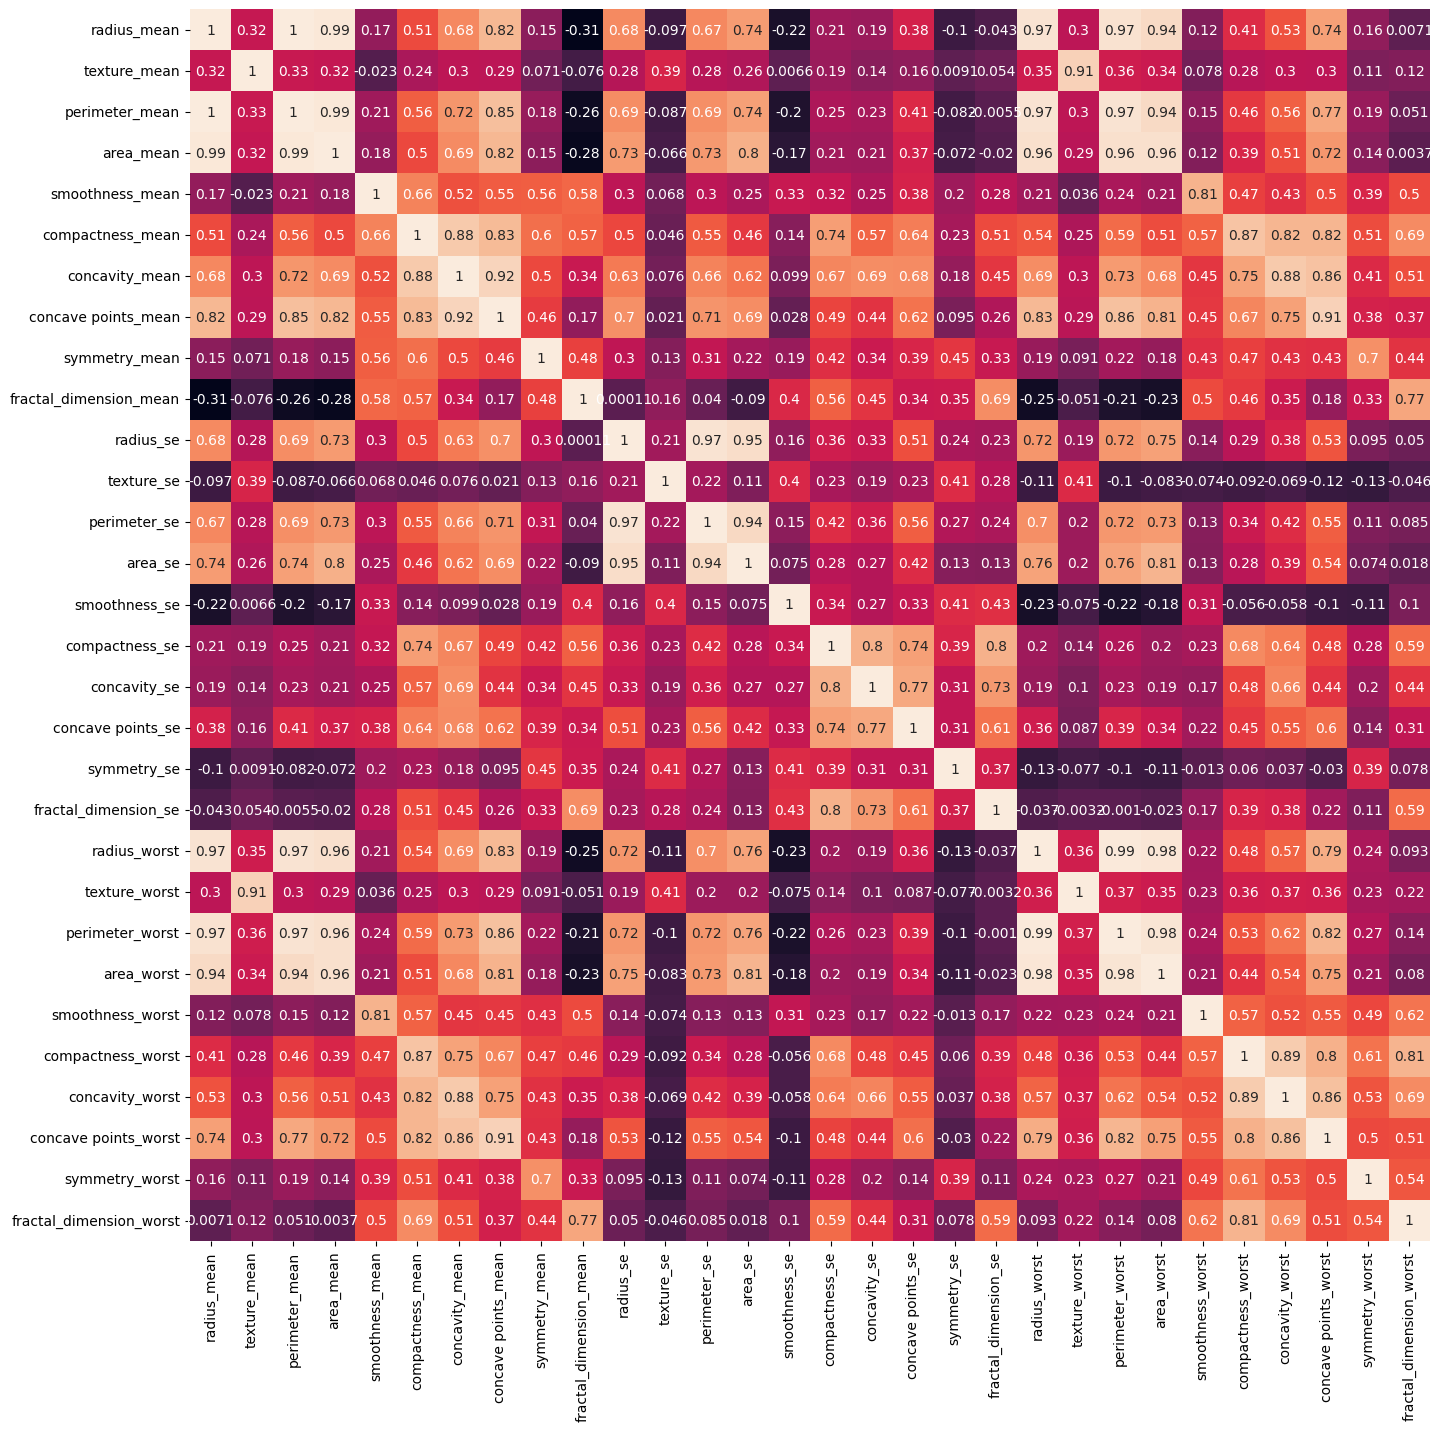

In [10]:
# makeing the X and y here because it is easier 
X = df.drop(columns=["id","diagnosis"])
y = df["diagnosis"]
matrix = X.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(matrix,annot=True,cbar=False)

Okay, some attributes correlate, but we have so many that it makes little difference in this scenario. It would still be preferable to delete the corresponding features, but we shall go with all of them.

We can now separately train and test the bagging and boosting algorithms. Let's begin with bagging using three distinct classifiers.
I intend to employ the classifiers svc, KNeighborsClassifier, and LogisticRegression. 



In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y) # we will be using this for every part

# Bagging

In [34]:
# We will use these classifiers by looping through them. 
classifiers = [["SVC",svm.SVC()],["logistic regression",LogisticRegression()],["KNeighbors",KNeighborsClassifier()]]

accuracy_pred_dict = {}

for name , classifier in classifiers:
    clf = BaggingClassifier(estimator=classifier, n_estimators=10, random_state=0)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy_pred_dict[name] = accuracy_score(y_test, pred)

clf = svm.SVC() # are dummy test see it is better then with bagging
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
accuracy_pred_dict["SVC(dummy)"] = accuracy_score(y_test, pred)




C:\Users\marsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

In [35]:
for key in accuracy_pred_dict:
    print(key, 'accuracy score = ', accuracy_pred_dict[key])

SVC accuracy score =  0.9370629370629371
logistic regression accuracy score =  0.958041958041958
KNeighbors accuracy score =  0.9300699300699301
SVC(dummy) accuracy score =  0.9370629370629371


As we can see, the algorithm's precision is really near.
The logistic regression model is the most accurate of the three. The bagging could be the reason. Bagging is a technique in which a large number of subsets of the original training dataset are bootstrapped. Each subset is used to train a unique base model, which is frequently done using the same learning approach. These base models are combined to produce predictions, either through a voting mechanism (for classification problems) or through averaging (for regression problems). Bagging is based on the principle of training several models on various subsets of data. The logisctic regression is by far the simplest of the three algrotims I utilized. The data is also quite great and includes a lot of features and only two classes. This makes it a lot easier to vote for one of the two classes.
logisctic regression reduces model variance by training numerous base estimators on various subsets of data. This is especially beneficial if the logistic regression model overfits the training data.
Bagging aggregates predictions from many base estimators, resulting in more robust and consistent predictions. It can lessen the impact of outliers or noisy cases in the dataset.
Taking advantage of the advantages of logistic regression: For binary classification problems, logistic regression is a popular and successful approach. You can take advantage of its qualities, such as interpretable coefficients and probabilistic predictions, by employing it as the base estimator in bagging.


# Boosting

In [30]:
# just put 50 in there for fun. it wont do well but I just want to see we can plot the accuracy against the estimators
estimators = [10,50,100,150,200,250,300,400,500,1000]
accuracy_pred_dict = {}

for estimator in estimators:
    clf = AdaBoostClassifier(n_estimators=estimator, random_state=0)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy_pred_dict[f'N:{estimator}'] = accuracy_score(y_test, pred)

In [31]:
for key in accuracy_pred_dict:
    print(key, 'accuracy score = ', accuracy_pred_dict[key])

N:10 accuracy score =  0.9370629370629371
N:50 accuracy score =  0.951048951048951
N:100 accuracy score =  0.951048951048951
N:150 accuracy score =  0.958041958041958
N:200 accuracy score =  0.951048951048951
N:250 accuracy score =  0.951048951048951
N:300 accuracy score =  0.951048951048951
N:400 accuracy score =  0.951048951048951
N:500 accuracy score =  0.951048951048951
N:1000 accuracy score =  0.951048951048951


Adding more estimators to boosting does not necessarily guarantee an improvement in accuracy. In fact, increasing the number of estimators beyond a certain point can lead to overfitting and a decrease in overall performance. In our case it is fine and the best estimator seems to be the n:150 but it is not noticible.
Here are a few reasons why adding more estimators to boosting may not improve accuracy:

Overfitting: The goal of boosting is to iteratively repair the errors committed by earlier models. If the number of estimators is too great, the model may become excessively complex and begin to memorize the training data rather than understanding the underlying patterns. Overfitting occurs when a model performs well on training data but performs badly on unseen data.

Boosting might be sensitive to noisy or mislabeled data points due to noise amplification. As the number of estimators grows, the algorithm may give too much weight to noisy examples, resulting in decreased accuracy.

Boosting involves training many estimators successively, with each subsequent estimator seeking to rectify the mistakes of the preceding ones. As the number of estimators increases, so does the algorithm's computational complexity, which can make it more resource-intensive and time-consuming.
